In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from neurodyn import *
import numpy as np
import matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import scipy.stats as stats
from matplotlib_tufte import *
setup()

1. generate the 3D grid, z-mapping ordering on the last two components

In [26]:
def generate_v123(mapping: BinMapping):
	v23 = mapping.inverse_samples(centered=True)
	v1 = np.linspace(0, 1-1/mapping.nx, mapping.nx) + 1/(2*mapping.nx)
	v123 = np.hstack((np.repeat(v1, len(v23))[:, None], np.tile(v23, (len(v1), 1))))
	return v123

In [27]:
mapping = ZMapping(nrec=8)
v123 = generate_v123(mapping)

2. generate samples

In [28]:
params = LowRankCyclingRNNParams.new_sampled_valentin(mapping_samples=v123, phi=sigmoid, I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
F_avgd = params.F.reshape((2**(2*mapping.nrec), 2**mapping.nrec, 3)).mean(axis=1)
G_avgd = params.G.reshape((2**(2*mapping.nrec), 2**mapping.nrec, 3)).mean(axis=1)

3. run simulations

In [29]:
# we run a simulation with lower nrec, because it is expensive. the full simulation takes 2**(3*nrec)=8**nrec samples !
params_ = LowRankCyclingRNNParams.new_sampled_valentin(mapping_samples=generate_v123(ZMapping.new_nrec(5)), phi=params.phi, I_ext=params.I_ext, exclude_self_connections=params.exclude_self_connections, delta=params.delta, shift=params.shift)
rnn = LowRankCyclingRNN(params_)
res = rnn.simulate(h0=params_.F[:, 0], t_span=(0, 80), progress=True)

simulating LowRankCyclingRNN{N=32768, p=3, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=80.000 of 80 [00:21<00:00]


In [30]:
params_down = LowRankCyclingRNNParams(F=F_avgd, G=G_avgd, phi=params.phi, I_ext=params.I_ext, exclude_self_connections=params.exclude_self_connections, delta=params.delta, shift=params.shift)
rnn_down = LowRankCyclingRNN(params_down)
res_down = rnn_down.simulate(h0=params_down.F[:, 0], t_span=(0, 80), progress=True)

simulating LowRankCyclingRNN{N=65536, p=3, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=80.000 of 80 [00:42<00:00]


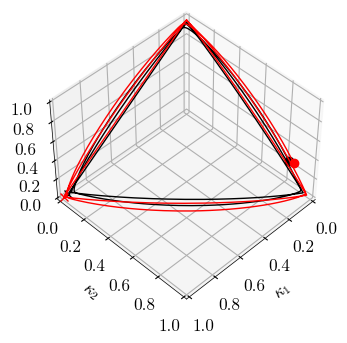

In [46]:
%matplotlib inline
plt.close('all')
proj = projection(rnn, res.h)
proj_down = projection(rnn_down, res_down.h)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), layout='constrained')
ax.plot(*proj, color='black')
ax.plot(*proj[:, 0], 'x', color='black')
ax.plot(*proj[:, -1], 'o', color='black')
ax.plot(*proj_down, color='red')
ax.plot(*proj_down[:, 0], 'x', color='red')
ax.plot(*proj_down[:, -1], 'o', color='red')
ax.set_xlabel('$\\kappa_1$'); ax.set_ylabel('$\\kappa_2$'); ax.set_zlabel('$\\kappa_3$')
ax.view_init(elev=45, azim=45)
ax.set_xlim((0,1)); ax.set_ylim((0,1)); ax.set_zlim((0,1))
plt.show()

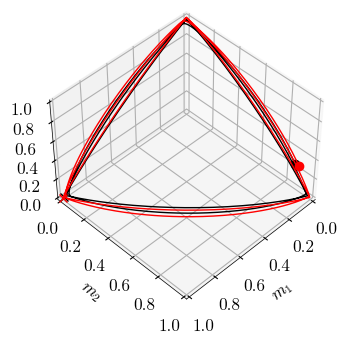

In [45]:
%matplotlib inline
plt.close('all')
m = overlap(rnn, res.h)
m_down = overlap(rnn_down, res_down.h)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), layout='constrained')
ax.plot(*m, color='black')
ax.plot(*m[:, 0], 'x', color='black')
ax.plot(*m[:, -1], 'o', color='black')
ax.plot(*m_down, color='red')
ax.plot(*m_down[:, 0], 'x', color='red')
ax.plot(*m_down[:, -1], 'o', color='red')
ax.set_xlabel('$m_1$'); ax.set_ylabel('$m_2$'); ax.set_zlabel('$m_3$')
ax.view_init(elev=45, azim=45)
ax.set_xlim((0,1)); ax.set_ylim((0,1)); ax.set_zlim((0,1))
plt.show()

4. visualize the 3D embedding and the 2D embedding

In [33]:
from matplotlib.colors import LinearSegmentedColormap

cmap_bi = LinearSegmentedColormap.from_list("", ["#ff0080","#ff0080","#a349a4","#0000ff","#0000ff"])
cmap_bi_r = LinearSegmentedColormap.from_list("", list(reversed(["#ff0080","#ff0080","#a349a4","#0000ff","#0000ff"])))
cmap_trans = LinearSegmentedColormap.from_list("", ["#55CDFC","#55CDFC","#FFFFFF","#FFFFFF","#F7A8B8","#F7A8B8"])

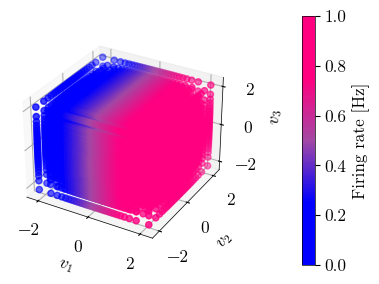

In [34]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
sc = ax.scatter(
	params_.F[:, 0], params_.F[:, 1], params_.F[:, 2],
	c=params.phi(res.h[:, 0]),
	cmap=cmap_bi_r, vmin=0, vmax=1,
)
fig.colorbar(sc, label='Firing rate [Hz]', pad=0.2)
ax.set_xlabel('$v_1$'); ax.set_ylabel('$v_2$'); ax.set_zlabel('$v_3$')
plt.show()

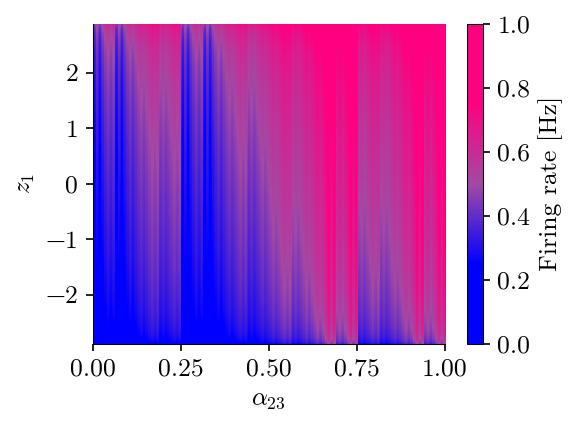

In [35]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(dpi=150)
im = ax.imshow(
	params.phi(res_down.h[:, 10].reshape((2**mapping.nrec, 2**mapping.nrec))),
	extent=(0, 1, params_down.F[:, 0].min(), params_down.F[:, 0].max()),
	cmap=cmap_bi_r, vmin=0, vmax=1,
	aspect='auto',
	origin='lower',
)
fig.colorbar(im, label='Firing rate [Hz]')
# ax.pcolormesh(res_down.h[:, 10].reshape((2**mapping.nrec, 2**mapping.nrec)), v23, linewidth=0.5, edgecolors='white', cmap='coolwarm')
ax.set_ylabel('$z_1$')
ax.set_xlabel('$\\alpha_{23}$')
# ax.set_ylim((params_down.F[:, 0].min(), params_down.F[:, 1].max()))
# ax.set_xlim((0,1))
plt.show()

5. apply the Z-mapping on $z_1, \alpha_{23}$

We reinterpret the downsampled F as if it had been obtained using column mapping, i.e. we just have meshgrid that obtained $z_1$ and $\alpha_{23}$

In [36]:
# find the indices of the Z-Mapping relative to the meshgrid, so that we can rearrange the samples in the downsampled F
idx_sort = np.argsort(mapping.indices(ColumnMapping.new_nrec(mapping.nrec).inverse_samples()))

In [37]:
F_avgd2 = params_down.F[idx_sort].reshape(2**mapping.nrec, 2**mapping.nrec, 3).mean(axis=1)
G_avgd2 = params_down.G[idx_sort].reshape(2**mapping.nrec, 2**mapping.nrec, 3).mean(axis=1)

6. simulate dynamics in the 1D mapping $\alpha_{123}$

In [42]:
params_down2 = LowRankCyclingRNNParams(F=F_avgd2, G=G_avgd2, phi=params.phi, I_ext=params.I_ext, exclude_self_connections=params.exclude_self_connections, delta=params.delta, shift=params.shift)
rnn_down2 = LowRankCyclingRNN(params_down2)
res_down2 = rnn_down2.simulate(h0=params_down2.F[:, 0], t_span=(0, 80))

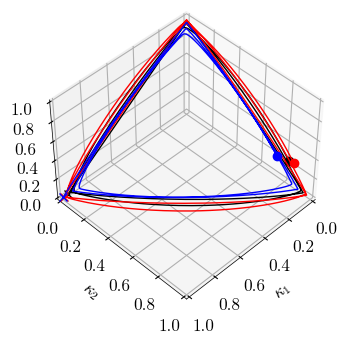

In [44]:
%matplotlib inline
plt.close('all')
proj_down2 = overlap(rnn_down2, res_down2.h)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), layout='constrained')
ax.plot(*proj, color='black')
ax.plot(*proj[:, 0], 'x', color='black')
ax.plot(*proj[:, -1], 'o', color='black')
ax.plot(*proj_down, color='red')
ax.plot(*proj_down[:, 0], 'x', color='red')
ax.plot(*proj_down[:, -1], 'o', color='red')
ax.plot(*proj_down2, color='blue')
ax.plot(*proj_down2[:, 0], 'x', color='blue')
ax.plot(*proj_down2[:, -1], 'o', color='blue')
ax.set_xlabel('$\\kappa_1$'); ax.set_ylabel('$\\kappa_2$'); ax.set_zlabel('$\\kappa_3$')
ax.view_init(elev=45, azim=45)
ax.set_xlim((0,1)); ax.set_ylim((0,1)); ax.set_zlim((0,1))
plt.show()

7. the field in 1D

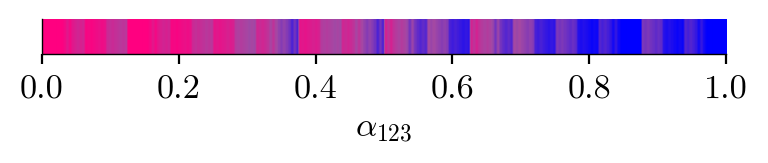

In [51]:
fig, ax = plt.subplots(dpi=200)
im = ax.imshow(
	params.phi(res_down2.h[:, 10][None, :]),
	extent=((0,1,0,1)), aspect=1/20,
	cmap=cmap_bi, vmin=0, vmax=1,
)
# fig.colorbar(im, label='Firing rate [Hz]', orientation='horizontal')
ax.set_xlabel('$\\alpha_{123}$')
ax.yaxis.set_visible(False)
plt.show()

## anim

In [47]:
from pathlib import Path
from math import ceil
from tqdm import tqdm
from matplotlib import animation

def anim(outpath: Path, time_stride: int = 1):
	fig, axes = plt.subplots(ncols=4, figsize=(4*3, 3), layout='tight')

	ss = axes[0].get_subplotspec()
	axes[0].remove()
	axes[0] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	sc3d = axes[0].scatter(
		params_.F[:, 0], params_.F[:, 1], params_.F[:, 2],
		c=params.phi(res.h[:, 0]),
		cmap=cmap_bi_r, vmin=0, vmax=1,
	)
	axes[0].set_xlabel('$z_1$'); axes[0].set_ylabel('$z_2$'); axes[0].set_zlabel('$z_3$')
	axes[0].set_title('3D embedding')

	im2d = axes[1].imshow(
		params.phi(res_down.h[:, 0].reshape((2**mapping.nrec, 2**mapping.nrec))),
		extent=(0, 1, params_down.F[:, 0].min(), params_down.F[:, 0].max()),
		cmap=cmap_bi_r, vmin=0, vmax=1,
		aspect='auto',
		origin='lower',
	)
	axes[1].set_ylabel('$z_1$'); axes[1].set_xlabel('$\\alpha_{23}$')
	axes[1].set_title('2D embedding')

	im1d = axes[2].imshow(
		params.phi(res_down2.h[:, 0][None, :]),
		extent=((0,1,0,1)), aspect=1/5,
		cmap=cmap_bi, vmin=0, vmax=1,
	)
	fig.colorbar(im, ax=axes[2], label='Firing rate [Hz]', orientation='horizontal', pad=0.4)
	axes[2].set_xlabel('$\\alpha_{123}$')
	axes[2].yaxis.set_visible(False)
	axes[2].set_title('1D embedding')

	m = overlap(rnn, res.h)
	ss = axes[3].get_subplotspec()
	axes[3].remove()
	axes[3] = fig.add_subplot(ss, projection='3d')  # replace by 3D axis
	lat_line = axes[3].plot(*m[:, :1], color='black')[0]
	lat_cur = axes[3].plot(*m[:, :1], 'o', color='black')[0]
	axes[3].set_xlabel('$\\kappa_1$'); axes[3].set_ylabel('$\\kappa_2$'); axes[3].set_zlabel('$\\kappa_3$')
	axes[3].set_xlim((0, 1)); axes[3].set_ylim((0, 1)); axes[3].set_zlim((0, 1))
	axes[3].view_init(elev=45, azim=45)
	axes[3].set_title('Latent trajectory')

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the 3D scatter
			sc3d.set_array(params.phi(res.h[:, idt]))

			# update the 2D image
			im2d.set_data(params.phi(res_down.h[:, idt].reshape((2**mapping.nrec, 2**mapping.nrec))))

			# update the 1D image
			im1d.set_data(params.phi(res_down2.h[:, idt][None, :]))

			# update the latent trajectory
			lat_line.set_data_3d(*m[:, :idt+1])
			lat_cur.set_data_3d(*m[:, idt:idt+1])

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()

anim('animations/embedding_3d_2d_1d.mp4', time_stride=4)

100%|██████████| 202/202 [05:56<00:00,  1.77s/it]


## effective sampling locations when we take the averages

In [28]:
# mapping = ZMapping(nrec=2)
mapping = ZMapping(nrec=3)
v123 = generate_v123(mapping)

In [29]:
# find the indices of the Z-Mapping relative to the meshgrid, so that we can rearrange the samples in the downsampled F
idx_sort = np.argsort(mapping.indices(ColumnMapping.new_nrec(mapping.nrec).inverse_samples()))
v123_avgd = v123.reshape((2**(2*mapping.nrec), 2**mapping.nrec, 3)).mean(axis=1)
v123_avgd2 = v123_avgd[idx_sort].reshape(2**mapping.nrec, 2**mapping.nrec, 3).mean(axis=1)

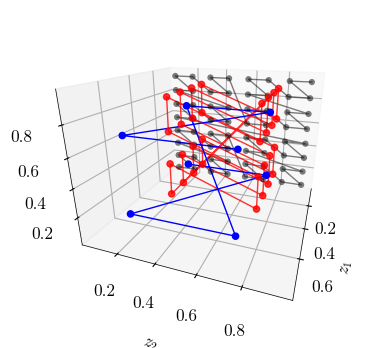

In [33]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), layout='constrained')
# ax.plot(*v123[:2**(3*mapping.nrec-2)].T, color='black', alpha=0.2)
# ax.scatter(*v123[:2**(3*mapping.nrec-2)].T, color='black', alpha=0.2, linewidths=0.0)
ax.plot(*v123[:2**(2*mapping.nrec)].T, color='black', alpha=0.5)
ax.scatter(*v123[:2**(2*mapping.nrec)].T, color='black', alpha=0.5, linewidths=0.0)
ax.plot(*v123_avgd[:2**(2*mapping.nrec-1)].T, color='red', alpha=0.8)
ax.scatter(*v123_avgd[:2**(2*mapping.nrec-1)].T, color='red', alpha=0.8)
# ax.plot(*v123_avgd.T, color='red')
# ax.scatter(*v123_avgd.T, color='red', alpha=1)
ax.plot(*v123_avgd2.T, color='blue')
ax.scatter(*v123_avgd2.T, alpha=1, color='blue')
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$'); ax.set_zlabel('$z_3$')
# ax.set_xlim((0,1)); ax.set_ylim((0,1)); ax.set_zlim((0,1))
ax.set_proj_type('persp', focal_length=0.2)
ax.view_init(elev=20, azim=20)
plt.show()